Before we get started, a couple of reminders to keep in mind when using iPython notebooks:

- Remember that you can see from the left side of a code cell when it was last run if there is a number within the brackets.
- When you start a new notebook session, make sure you run all of the cells up to the point where you last left off. Even if the output is still visible from when you ran the cells in your previous session, the kernel starts in a fresh state so you'll need to reload the data, etc. on a new session.
- The previous point is useful to keep in mind if your answers do not match what is expected in the lesson's quizzes. Try reloading the data and run all of the processing steps one by one in order to make sure that you are working with the same variables and data that are at each quiz stage.


## Load Data from CSVs

In [1]:
import unicodecsv

## Longer version of code (replaced with shorter, equivalent version below)

# enrollments = []
# f = open('enrollments.csv', 'rb')
# reader = unicodecsv.DictReader(f)
# for row in reader:
#     enrollments.append(row)
# f.close()

with open('data/enrollments.csv', 'rb') as f:
    reader = unicodecsv.DictReader(f)
    enrollments = list(reader)

In [2]:
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
## Then look at the first row of each table.

with open('data/daily_engagement.csv') as f:
    reader = unicodecsv.DictReader(f)
    daily_engagement = list(reader)
    
with open('data/project_submissions.csv') as f:
    reader = unicodecsv.DictReader(f)
    project_submissions = list(reader)

## Fixing Data Types

In [3]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [4]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'acct': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [5]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

Note when running the above cells that we are actively changing the contents of our data variables. If you try to run these cells multiple times in the same session, an error will occur.

## Investigating the Data

In [6]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys)
## in each table.
total_enrollment_records = len(enrollments)
total_daily_engagement_records = len(daily_engagement)
total_project_submission_records = len(project_submissions)

unique_enrollments = set([enrollment.get('account_key') for enrollment in enrollments])
unique_daily_engagement = set([engagement.get('acct') for engagement in daily_engagement])
unique_project_submissions = set([submission.get('account_key') for submission in project_submissions])

unique_enrollment_records = len(unique_enrollments)
unique_daily_engagement_records = len(unique_daily_engagement)
unique_project_submission_records = len(unique_project_submissions)

## Problems in the Data

In [7]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".
map(lambda x: x.update({'account_key': x.pop('acct')}), daily_engagement)
print daily_engagement[0].get('account_key')

0


## Missing Engagement Records

In [8]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.

enrollments_missing_engagement = [enrollment for enrollment in enrollments if enrollment.get('account_key') not in unique_daily_engagement]
print enrollments_missing_engagement[0]

{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 12, 0, 0), u'account_key': u'1219', u'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), u'days_to_cancel': 0}


## Checking for More Problem Records

In [9]:
#####################################
#                 5                 #
#####################################

## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.
surprising_datapoints = [missing_engagement for missing_engagement in enrollments_missing_engagement if missing_engagement.get('join_date') != missing_engagement.get('cancel_date')]
print len(surprising_datapoints)

3


## Tracking Down the Remaining Problems

In [10]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [11]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [12]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


## Refining the Question

In [13]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

paid_students = {}
for unique_enrollment in unique_enrollments:
    for enrollment in non_udacity_enrollments:
        if unique_enrollment == enrollment.get('account_key'):
            if (enrollment.get('days_to_cancel') is None) or (enrollment.get('days_to_cancel') > 7):
                if (unique_enrollment not in paid_students.keys()) or \
                    (enrollment.get('join_date') > paid_students.get(unique_enrollment)):
                        paid_students.update({unique_enrollment: enrollment.get('join_date')})
            
print len(paid_students.keys())

995


## Getting Data from First Week

In [14]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [27]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

paid_engagement_in_first_week = []
for paid_student in paid_students.keys():
    for engagement in non_udacity_engagement:
        if paid_student == engagement.get('account_key'):
            if within_one_week(paid_students.get(paid_student), engagement.get('utc_date')):
                paid_engagement_in_first_week.append(engagement)
                
print len(paid_engagement_in_first_week)

6919


## Exploring Student Engagement

In [16]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [17]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
total_minutes_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

In [18]:
import numpy as np

# Summarize the data about minutes spent in the classroom
total_minutes = total_minutes_by_account.values()
print 'Mean:', np.mean(total_minutes)
print 'Standard deviation:', np.std(total_minutes)
print 'Minimum:', np.min(total_minutes)
print 'Maximum:', np.max(total_minutes)

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


## Debugging Data Analysis Code

In [19]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.

student_max_minutes = None
max_minutes = 0

for student, total_minutes in total_minutes_by_account.items():
    if total_minutes > max_minutes:
        max_minutes = total_minutes
        student_with_max_minutes = student
        
print max_minutes

for engagement_record in paid_engagement_in_first_week:
    if engagement_record.get('account_key') == student_with_max_minutes:
        print engagement_record

3564.7332645
{u'lessons_completed': 4, u'num_courses_visited': 4, u'total_minutes_visited': 850.519339666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 9, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 6, u'total_minutes_visited': 872.633923334, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 10, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 2, u'total_minutes_visited': 777.018903666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 11, 0, 0)}
{u'lessons_completed': 2, u'num_courses_visited': 1, u'total_minutes_visited': 294.568774, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 12, 0, 0)}
{u'lessons_completed': 1, u'num_courses_visited': 3, u'total_minutes_visited': 471.2139785, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 13, 0, 0)}
{u'lessons_completed': 

## Lessons Completed in First Week

In [20]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.

import numpy as np

lessons_completed_by_account = {}
for account_key, engagement_records in engagement_by_account.items():
    lessons_completed = 0
    for engagement_record in engagement_records:
        lessons_completed += engagement_record.get('lessons_completed')
    lessons_completed_by_account.update({account_key: lessons_completed})
    
total_lessons_completed = lessons_completed_by_account.values()
print '{}: {}'.format('Mean', np.mean(total_lessons_completed))
print '{}: {}'.format('SD', np.std(total_lessons_completed))
print '{}: {}'.format('Minimum', np.min(total_lessons_completed))
print '{}: {}'.format('Maximum', np.max(total_lessons_completed))

Mean: 1.63618090452
SD: 3.00256129983
Minimum: 0
Maximum: 36


## Number of Visits in First Week

In [21]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.

import numpy as np

courses_visited_by_account = {}
for account_key, engagement_records in engagement_by_account.items():
    courses_visited = 0
    for engagement_record in engagement_records:
        if engagement_record.get('num_courses_visited') > 0:
            courses_visited += 1
    courses_visited_by_account.update({account_key: courses_visited})
    
total_courses_visited = courses_visited_by_account.values()
print '{}: {}'.format('Mean', np.mean(total_courses_visited))
print '{}: {}'.format('SD', np.std(total_courses_visited))
print '{}: {}'.format('Minimum', np.min(total_courses_visited))
print '{}: {}'.format('Maximum', np.max(total_courses_visited))

Mean: 2.86733668342
SD: 2.25519800292
Minimum: 0
Maximum: 7


In [70]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']
subway_submissions = [submission for submission in non_udacity_submissions \
                      if submission.get('lesson_key') in subway_project_lesson_keys]

passing_subway_accounts = set([submission.get('account_key') for submission in subway_submissions \
                               if submission.get('assigned_rating') in ('PASSED', 'DISTINCTION')])

print len(passing_subway_accounts)

passing_engagement = []
non_passing_engagement = []

for paid_engagement in paid_engagement_in_first_week:
    if paid_engagement.get('account_key') in passing_subway_accounts:
        passing_engagement.append(paid_engagement)
    else:
        non_passing_engagement.append(paid_engagement)

print len(passing_engagement)
print len(non_passing_engagement)

651
4527
2392


## Splitting out Passing Students

## Comparing the Two Student Groups

In [94]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).

import numpy as np

passing_accounts = [engagement.get('account_key') for engagement in passing_engagement]
non_passing_accounts = [engagement.get('account_key') for engagement in non_passing_engagement]

total_minutes_passing = [total_minutes_by_account.get(passing_account) for passing_account in passing_accounts \
                        if total_minutes_by_account.get(passing_account) is not None]
total_minutes_non_passing = [total_minutes_by_account.get(non_passing_account) for non_passing_account in non_passing_accounts \
                             if total_minutes_by_account.get(non_passing_account) is not None]

lessons_completed_passing = [lessons_completed_by_account.get(passing_account) for passing_account in passing_accounts \
                             if lessons_completed_by_account.get(passing_account) is not None]
lessons_completed_non_passing = [lessons_completed_by_account.get(non_passing_account) for non_passing_account in non_passing_accounts \
                                 if lessons_completed_by_account.get(non_passing_account) is not None]

courses_visited_passing = [courses_visited_by_account.get(passing_account) for passing_account in passing_accounts \
                          if courses_visited_by_account.get(passing_account) is not None]
courses_visited_non_passing = [courses_visited_by_account.get(non_passing_account) for non_passing_account in non_passing_accounts \
                               if courses_visited_by_account.get(non_passing_account) is not None]


print 'Mean Total Minutes Passing: {}'.format(np.mean(total_minutes_passing))
print 'Mean Total Minutes Non Passing: {}'.format(np.mean(total_minutes_non_passing))

print 'Mean Lessons Completed Passing: {}'.format(np.mean(lessons_completed_passing))
print 'Mean Lessons Completed Non Passing: {}'.format(np.mean(lessons_completed_non_passing))

print 'Mean Courses Visited Passing: {}'.format(np.mean(courses_visted_passing))
print 'Mean Courses Visited Non Passing: {}'.format(np.mean(courses_visited_non_passing))

Mean Total Minutes Passing: 394.49825286
Mean Total Minutes Non Passing: 144.800043968
Mean Lessons Completed Passing: 2.0525734482
Mean Lessons Completed Non Passing: 0.870819397993
Mean Courses Visited Passing: 3.38458140049
Mean Courses Visited Non Passing: 1.91806020067


## Making Histograms

(array([ 1865.,   237.,   115.,    63.,    42.,    14.,     7.,    35.,
            0.,    14.]),
 array([    0.        ,   176.85227493,   353.70454987,   530.5568248 ,
          707.40909973,   884.26137467,  1061.1136496 ,  1237.96592453,
         1414.81819947,  1591.6704744 ,  1768.52274933]),
 <a list of 10 Patch objects>)

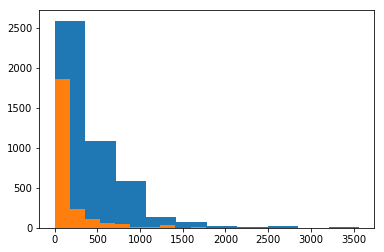

In [100]:
######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.

import matplotlib.pyplot as plt

%matplotlib inline
plt.hist(total_minutes_passing)
plt.hist(total_minutes_non_passing)

(array([ 2175.,   119.,    42.,    28.,     7.,     7.,     0.,     7.,
            0.,     7.]),
 array([  0. ,   2.7,   5.4,   8.1,  10.8,  13.5,  16.2,  18.9,  21.6,
         24.3,  27. ]),
 <a list of 10 Patch objects>)

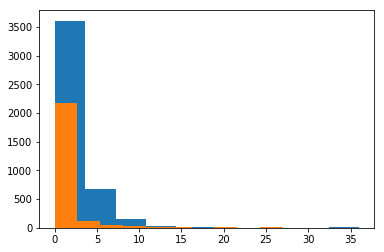

In [99]:
import matplotlib.pyplot

%matplotlib inline
plt.hist(lessons_completed_passing)
plt.hist(lessons_completed_non_passing)

(array([ 664.,  612.,  388.,    0.,  284.,  103.,    0.,  166.,  119.,   56.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

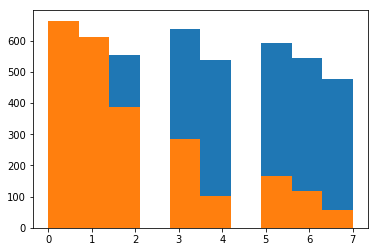

In [101]:
import matplotlib.pyplot

%matplotlib inline
plt.hist(courses_visited_passing)
plt.hist(courses_visited_non_passing)

## Improving Plots and Sharing Findings

In [ ]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.